Loading dataset...


C:\Users\HP\AppData\Local\Temp\ipykernel_15568\3582854433.py:10: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(raw_data_path)


Total Raw Records: 9609797
Complaints with Narratives: 2980756
Complaints without Narratives: 6629041


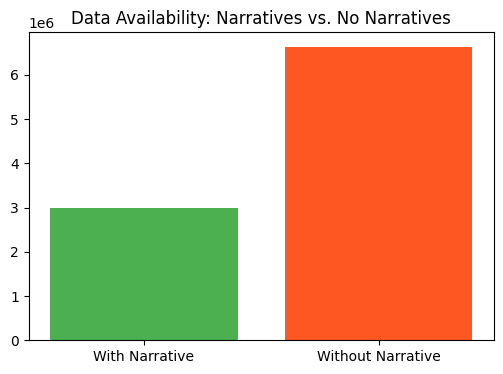

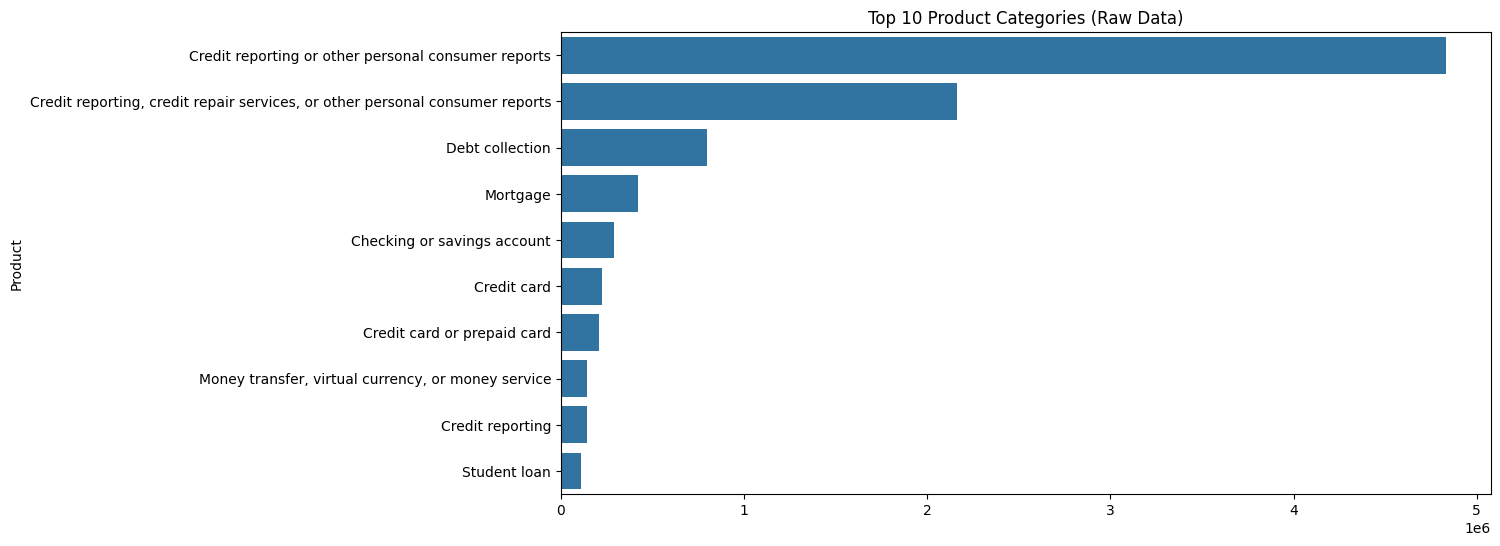

Filtered Dataset Size: 445576


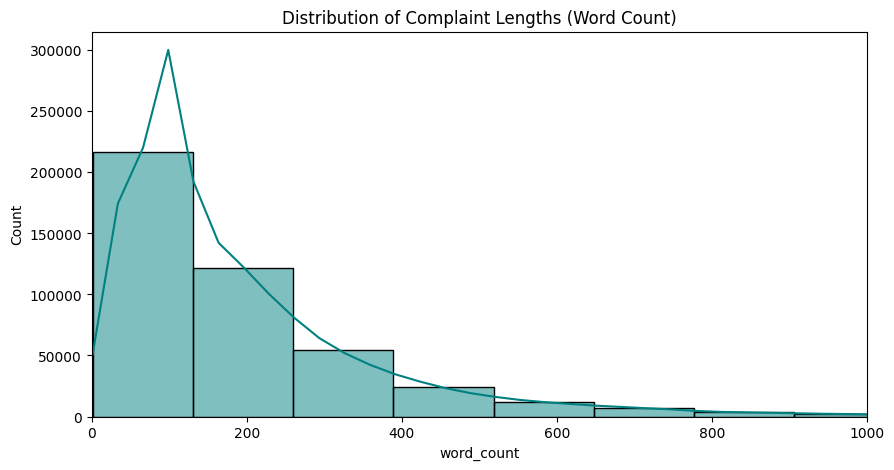

Very short complaints (<10 words): 2027
Very long complaints (>1000 words): 5298
                            Consumer complaint narrative  \
12237  A XXXX XXXX card was opened under my name by a...   
12532  I made the mistake of using my wellsfargo debi...   
13280  Dear CFPB, I have a secured credit card with c...   
13506  I have a Citi rewards cards. The credit balanc...   
13955  b'I am writing to dispute the following charge...   

                                       cleaned_narrative  
12237  a card was opened under my name by a fraudster...  
12532  i made the mistake of using my wellsfargo debi...  
13280  dear cfpb i have a secured credit card with ci...  
13506  i have a citi rewards cards the credit balance...  
13955  bi am writing to dispute the following charges...  


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# 1. Load the full dataset
# Ensure the file exists in data/raw/
raw_data_path = "../data/raw/complaints.csv"
print("Loading dataset...")
df = pd.read_csv(raw_data_path)

print(f"Total Raw Records: {len(df)}")

# 2. EDA: Analyze Missing Narratives
# Identify complaints with vs without narratives
missing_narratives = df['Consumer complaint narrative'].isna().sum()
present_narratives = len(df) - missing_narratives

print(f"Complaints with Narratives: {present_narratives}")
print(f"Complaints without Narratives: {missing_narratives}")

# Visualization 1: Narratives Presence
plt.figure(figsize=(6, 4))
plt.bar(['With Narrative', 'Without Narrative'], [present_narratives, missing_narratives], color=['#4CAF50', '#FF5722'])
plt.title('Data Availability: Narratives vs. No Narratives')
plt.show()

# 3. EDA: Product Distribution (Raw Data)
plt.figure(figsize=(12, 6))
product_counts = df['Product'].value_counts().head(10) # Top 10 for readability
sns.barplot(y=product_counts.index, x=product_counts.values)
plt.title('Top 10 Product Categories (Raw Data)')
plt.show()

# 4. Filtering Logic
# Mapping the raw CFPB categories to the 5 project requirements
TARGET_MAPPING = {
    "Credit card": "Credit Card",
    "Credit card or prepaid card": "Credit Card",
    "Payday loan, title loan, or personal loan": "Personal Loan",
    "Checking or savings account": "Savings Account",
    "Money transfer, virtual currency, or money service": "Money Transfers",
    "Money transfers": "Money Transfers"
}

# Apply Mapping
df['Standardized_Product'] = df['Product'].map(TARGET_MAPPING)

# Filter: Keep only mapped products AND rows with narratives
df_clean = df.dropna(subset=['Standardized_Product', 'Consumer complaint narrative']).copy()

print(f"Filtered Dataset Size: {len(df_clean)}")

# 5. EDA: Narrative Length Analysis
# Calculate word count for valid narratives
df_clean['word_count'] = df_clean['Consumer complaint narrative'].apply(lambda x: len(str(x).split()))

# Visualization 2: Word Count Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df_clean['word_count'], bins=50, kde=True, color='teal')
plt.xlim(0, 1000) # Limit x-axis to zoom in
plt.title('Distribution of Complaint Lengths (Word Count)')
plt.show()

# Check for extremely short/long texts
print("Very short complaints (<10 words):", len(df_clean[df_clean['word_count'] < 10]))
print("Very long complaints (>1000 words):", len(df_clean[df_clean['word_count'] > 1000]))

# 6. Text Cleaning
def basic_clean(text):
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r'x{2,}', '', text) # Remove 'XXXX' anonymization
    text = text.replace("i am writing to file a complaint", "") # Remove boilerplate
    text = re.sub(r'[^\w\s]', '', text) # Remove special chars
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra spaces
    return text

df_clean['cleaned_narrative'] = df_clean['Consumer complaint narrative'].apply(basic_clean)

# Preview
print(df_clean[['Consumer complaint narrative', 'cleaned_narrative']].head())

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

# --- SETUP ---
os.makedirs("../reports/figures", exist_ok=True)
os.makedirs("../data/processed", exist_ok=True)

RAW_DATA_PATH = "../data/raw/complaints.csv"
PROCESSED_DATA_PATH = "../data/processed/filtered_complaints.csv"

# Mapping Logic
TARGET_MAPPING = {
    "Credit card": "Credit Card",
    "Credit card or prepaid card": "Credit Card",
    "Payday loan, title loan, or personal loan": "Personal Loan",
    "Checking or savings account": "Savings Account",
    "Money transfer, virtual currency, or money service": "Money Transfers",
    "Money transfers": "Money Transfers"
}

# --- 1. LOAD & FILTER IN CHUNKS (Low RAM Safe) ---
print("Processing data in chunks to save memory...")

# We only load columns we actually need to analysis or filtering
# This drastically reduces memory usage
cols_to_use = ['Product', 'Consumer complaint narrative', 'Complaint ID', 'Issue']

filtered_chunks = []
chunk_size = 50000  # Process 50k rows at a time

# Create an iterator to read the file in parts
try:
    reader = pd.read_csv(
        RAW_DATA_PATH,
        usecols=cols_to_use,
        chunksize=chunk_size,
        dtype=str  # Read everything as text to avoid type errors
    )

    for i, chunk in enumerate(reader):
        # Filter 1: Map Products
        chunk['category'] = chunk['Product'].map(TARGET_MAPPING)

        # Filter 2: Drop rows clearly irrelevant (unmapped product OR no narrative)
        chunk_filtered = chunk.dropna(subset=['category', 'Consumer complaint narrative'])

        if not chunk_filtered.empty:
            filtered_chunks.append(chunk_filtered)

        print(f"Processed chunk {i+1}...", end='\r')

    # Combine all useful pieces into one dataframe
    print("\nMerging chunks...")
    if not filtered_chunks:
        raise ValueError("No matching records found. Check your CSV or mapping.")

    df = pd.concat(filtered_chunks, ignore_index=True)
    print(f"Successfully loaded {len(df)} relevant records.")

except Exception as e:
    print(f"\nCRITICAL ERROR: {e}")
    print("Tip: Ensure your CSV file is not corrupted and contains the headers: 'Product' and 'Consumer complaint narrative'")
    raise e

# --- 2. EDA: VISUALIZATION ---
# Now that 'df' is much smaller (only relevant rows), we can visualize safely

# Chart 1: Product Distribution
plt.figure(figsize=(10, 6))
sns.countplot(y=df['category'], order=df['category'].value_counts().index, palette='viridis')
plt.title('Distribution of Complaints by Product (Filtered)')
plt.xlabel('Number of Complaints')
plt.tight_layout()
plt.savefig('../reports/figures/02_product_distribution.png')
plt.close() # Close plot to free memory
print("Saved Product Distribution Chart.")

# --- 3. CLEANING ---
def clean_text(text):
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r'x{2,}', '', text)  # Remove 'XXXX'
    text = text.replace("i am writing to file a complaint", "")
    text = re.sub(r'[^\w\s]', '', text)  # Remove special chars
    text = re.sub(r'\s+', ' ', text).strip()
    return text

print("Cleaning text narratives...")
df['cleaned_narrative'] = df['Consumer complaint narrative'].apply(clean_text)

# Remove very short descriptions (< 10 chars)
df = df[df['cleaned_narrative'].str.len() > 10]

# --- 4. ANALYZE LENGTHS ---
df['word_count'] = df['cleaned_narrative'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 5))
sns.histplot(df['word_count'], bins=50, kde=True, color='teal')
plt.xlim(0, 1000)
plt.title('Distribution of Complaint Lengths (Word Count)')
plt.tight_layout()
plt.savefig('../reports/figures/03_word_count_distribution.png')
plt.close()
print("Saved Word Count Chart.")

# --- 5. SAVE ---
print(f"Saving {len(df)} cleaned records to {PROCESSED_DATA_PATH}...")
df.to_csv(PROCESSED_DATA_PATH, index=False)
print("Task 1 Complete!")

Processing data in chunks to save memory...
Processed chunk 193...
Merging chunks...
Successfully loaded 445576 relevant records.


C:\Users\HP\AppData\Local\Temp\ipykernel_15568\1126398452.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df['category'], order=df['category'].value_counts().index, palette='viridis')


Saved Product Distribution Chart.
Cleaning text narratives...
Saved Word Count Chart.
Saving 445568 cleaned records to ../data/processed/filtered_complaints.csv...
Task 1 Complete!


In [8]:
import pandas as pd
import os
import shutil
from sklearn.model_selection import train_test_split
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma
# UPDATED IMPORTS FOR NEW LANGCHAIN VERSION
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter

# --- CONFIGURATION ---
DATA_PATH = "../data/processed/filtered_complaints.csv"
VECTOR_STORE_PATH = "../vector_store/chroma_db"
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
SAMPLE_SIZE = 10000

def main():
    # 1. Load Data
    print("Loading processed data...")
    if not os.path.exists(DATA_PATH):
        raise FileNotFoundError(f"File not found: {DATA_PATH}. Did you run Task 1?")

    df = pd.read_csv(DATA_PATH)
    print(f"Total available records: {len(df)}")

    # 2. Stratified Sampling
    print(f"Selecting a balanced sample of {SAMPLE_SIZE} complaints...")
    try:
        sample_df, _ = train_test_split(
            df,
            train_size=SAMPLE_SIZE,
            stratify=df['category'],
            random_state=42
        )
    except Exception as e:
        print(f"Stratification warning: {e}. Falling back to random sampling.")
        sample_df = df.sample(n=SAMPLE_SIZE, random_state=42)

    print(f"Sample created. Shape: {sample_df.shape}")

    # 3. Prepare Documents
    print("Converting data to LangChain Document format...")
    documents = []
    for _, row in sample_df.iterrows():
        # Clean up metadata (ensure strings)
        meta = {
            "complaint_id": str(row.get('Complaint ID', 'N/A')),
            "product": str(row['category']),
            "issue": str(row.get('Issue', 'Unknown')),
            "company": str(row.get('Company', 'Unknown'))
        }
        doc = Document(
            page_content=str(row['cleaned_narrative']), # Ensure string
            metadata=meta
        )
        documents.append(doc)

    # 4. Chunking
    print("Splitting text into chunks...")
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=500,
        chunk_overlap=50,
        separators=["\n\n", "\n", ".", " "]
    )

    chunked_docs = text_splitter.split_documents(documents)
    print(f"Created {len(chunked_docs)} chunks from {SAMPLE_SIZE} complaints.")

    # 5. Embedding & Indexing
    print(f"Initializing Embedding Model ({MODEL_NAME})...")
    embeddings = HuggingFaceEmbeddings(model_name=MODEL_NAME)

    print("Creating Vector Database (ChromaDB)...")
    print("⚠️ This step might take 5-10 minutes. Please wait.")

    if os.path.exists(VECTOR_STORE_PATH):
        shutil.rmtree(VECTOR_STORE_PATH)

    vector_store = Chroma.from_documents(
        documents=chunked_docs,
        embedding=embeddings,
        persist_directory=VECTOR_STORE_PATH
    )

    print(f"✅ Success! Vector store saved to: {VECTOR_STORE_PATH}")
    print("Task 2 Complete. You are ready for the RAG Pipeline.")

if __name__ == "__main__":
    main()

Loading processed data...
Total available records: 445568
Selecting a balanced sample of 10000 complaints...
Sample created. Shape: (10000, 7)
Converting data to LangChain Document format...
Splitting text into chunks...
Created 27459 chunks from 10000 complaints.
Initializing Embedding Model (sentence-transformers/all-MiniLM-L6-v2)...


C:\Users\HP\PycharmProjects\CrediTrust Financial Intelligent Complaint Analysis\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\HP\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the '

Creating Vector Database (ChromaDB)...
⚠️ This step might take 5-10 minutes. Please wait.
✅ Success! Vector store saved to: ../vector_store/chroma_db
Task 2 Complete. You are ready for the RAG Pipeline.
